# Examples

In [1]:
from coffea.nanoevents import NanoEventsFactory, EDM4HEPSchema
import dask_awkward as dak
import dask
import hist.dask as hda
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import fastjet

In [2]:
events = NanoEventsFactory.from_root( 
    {"../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004" 
    ".Pe2e2h.eR.pL.n000.d_dstm_15090_*.slcio.edm4hep.root"
    :"events"},
    schemaclass=EDM4HEPSchema,
    permit_dask=True,
    metadata = {'b_field':5},
).events()

/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:63: UserWarning: Skipping PARAMETERS as it is it cannot be interpreted by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skipping _intMap as it is not interpretable by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.first as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.second as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skippin

### Introduction

Reconstructed Particles: `events.PandoraPFOs` \
Generated Particles: `events.MCParticlesSkimmed` \
Tracks: `events.MarlinTrkTracks` \
Clusters: `events.PandoraClusters` 

In [3]:
# this prints the main fields of an object 
events.PandoraPFOs.fields

['x', 'y', 'z', 't', 'charge', 'pdgId']

Also many other things that one might want from 4-vectors 

For example:\
`events.PandoraPFOs.pt` | transverse momentum of PFOs \
`.p` | momentum \
`.eta` | $\eta$ \
...


Also, the binary operators `&` and `|` must be used instead of `and` and `or` for awkward boolean arrays.

### Example 1
Plot the energy of all clusters.

{'from-uproot-08f9d2051ab3e4579ef30993895d2a69': ['PandoraClusters.energy']}

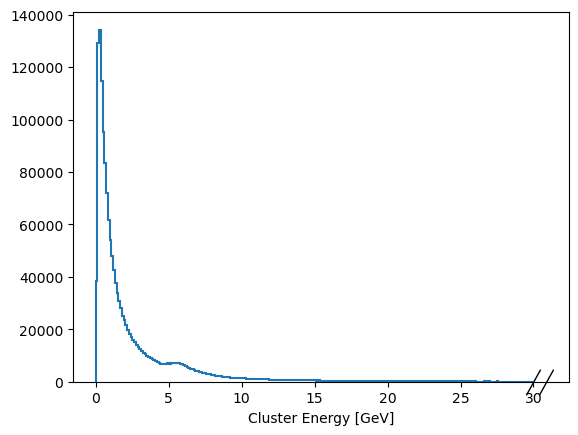

In [4]:
bins = 250
mini = 0
maxi = 30

energy_hist_clusters = (
    hda.Hist.new.Reg(bins, mini, maxi, name="energy", label="Cluster Energy [GeV]") 
    .Double()
    .fill(ak.flatten(events.PandoraClusters.energy))
)

energy_hist_clusters.compute().plot1d(label='PandoraClusters')
dak.necessary_columns(energy_hist_clusters)

### Example 2
Plot the $p_T$ of all tracks with $|\eta|<0.5$.

{'from-uproot-08f9d2051ab3e4579ef30993895d2a69': ['MarlinTrkTracks.omega',
  'MarlinTrkTracks.tanLambda',
  'MarlinTrkTracks.phi']}

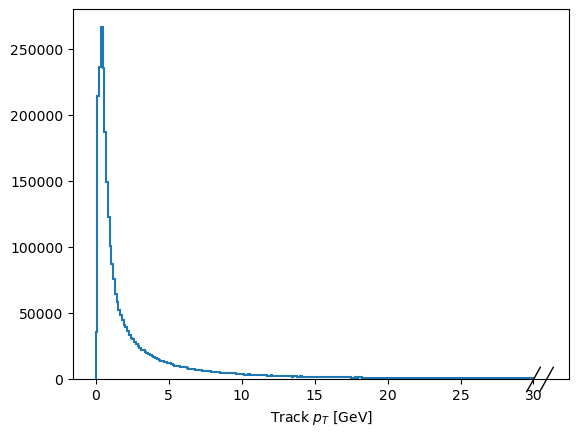

In [5]:
bins = 250
mini = 0
maxi = 30

energy_hist_clusters = (
    hda.Hist.new.Reg(bins, mini, maxi, name="pt", label="Track $p_T$ [GeV]") 
    .Double()
    .fill(ak.flatten(events.MarlinTrkTracks[events.MarlinTrkTracks.eta < 0.5].pt))
)

energy_hist_clusters.compute().plot1d(label='MarlinTrkTracks')
dak.necessary_columns(energy_hist_clusters)

### Example 3
Plot the $p_T$ of the tracks, clusters, Monte Carlo particles, and reconstructed particles with a logarithmic y axis.

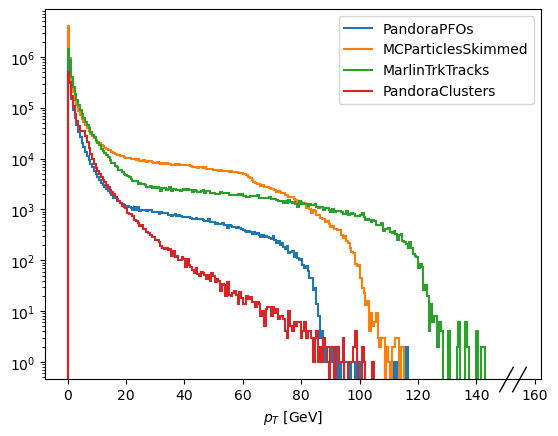

In [6]:
bins = 250
mini = 0
maxi = 150

pt_hist = {
    "PandoraPFOs": hda.Hist.new.Reg(
        bins, mini, maxi, name="pt", label="$p_T$ [GeV]"
    )
    .Double()
    .fill(ak.flatten(events.PandoraPFOs.pt)),
    
    "MCParticlesSkimmed": hda.Hist.new.Reg(
        bins, mini, maxi, name="pt", label="$p_T$ [GeV]"
    )
    .Double()
    .fill(ak.flatten(events.MCParticlesSkimmed.pt)),
    
    "MarlinTrkTracks": hda.Hist.new.Reg(
        bins, mini, maxi, name="pt", label="$p_T$ [GeV]"
    )
    .Double()
    .fill(ak.flatten(events.MarlinTrkTracks.pt)),
    
    "PandoraClusters": hda.Hist.new.Reg(
        bins, mini, maxi, name="pt", label="$p_T$ [GeV]"
    )
    .Double()
    .fill(ak.flatten(events.PandoraClusters.pt)),
}

out = dask.compute(pt_hist)[0]
fig, ax = plt.subplots(1, 1)

out["PandoraPFOs"].plot1d(ax=ax,label='PandoraPFOs')
out["MCParticlesSkimmed"].plot1d(ax=ax,label='MCParticlesSkimmed')
out["MarlinTrkTracks"].plot1d(ax=ax,label='MarlinTrkTracks')
out["PandoraClusters"].plot1d(ax=ax,label='PandoraClusters')
dak.necessary_columns(pt_hist)

ax.set_yscale('log')
plt.legend()

### Example 4
Plot the invariant mass of opposite charge muon pairs to show a Z-boson peak (for both Monte Carlo and reconstructed particles). 

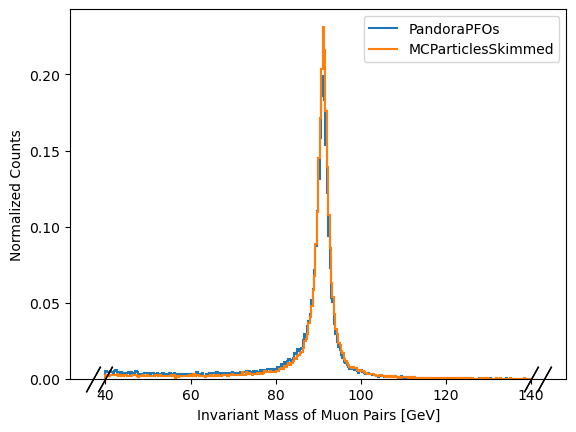

In [7]:
bins = 300
mini = 40
maxi = 140

# all muon pairs for reconstructed particles
reco_mupair = ak.combinations(
events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"]
)

# invariant mass of muon-antimuon pairs
reco_mus_mass = (reco_mupair.mu1 + reco_mupair.mu2)[reco_mupair.mu1.charge == -reco_mupair.mu2.charge].mass


# same calculations for generated particles
mc_mupair = ak.combinations(
    events.MCParticlesSkimmed[abs(events.MCParticlesSkimmed.pdgId) == 13], 2, fields=["mu1", "mu2"]
)
mc_mus_mass = (mc_mupair.mu1 + mc_mupair.mu2)[mc_mupair.mu1.charge == -mc_mupair.mu2.charge].mass


invmass_hist = {
    "PandoraPFOs": hda.Hist.new.Reg(
        bins, mini, maxi, name="invmass", label="Invariant Mass of Muon Pairs [GeV]"
    )
    .Double()
    .fill(ak.flatten(reco_mus_mass)),
    
    "MCParticlesSkimmed": hda.Hist.new.Reg(
        bins, mini, maxi, name="invmass", label="Invariant Mass of Muon Pairs [GeV]"
    )
    .Double()
    .fill(ak.flatten(mc_mus_mass)),
}

out = dask.compute(invmass_hist)[0]
fig, ax = plt.subplots(1, 1)

out["PandoraPFOs"].plot1d(ax=ax,label='PandoraPFOs',density=True)
out["MCParticlesSkimmed"].plot1d(ax=ax,label='MCParticlesSkimmed',density=True)
dak.necessary_columns(invmass_hist)

ax.set_ylabel('Normalized Counts')
plt.legend()

### Example 5
Plot the normalized momentum of all of the MC particles that are not linked to a reconstructed particle compared to those that are.

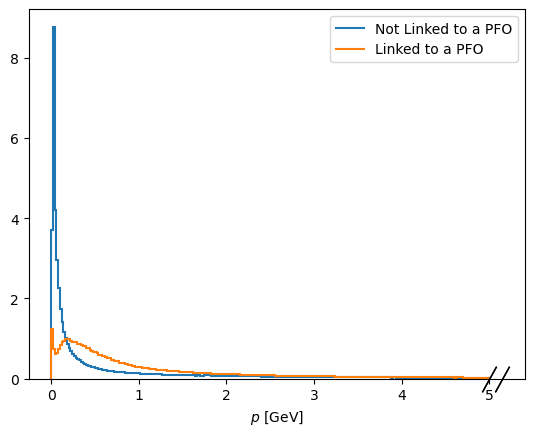

In [8]:
bins = 250
mini = 0
maxi = 5

non_reco = ak.is_none(events.MCParticlesSkimmed.matched_pfos,axis=1) # all the MC particles not linked to a pfo

p_hist = {
    "nolinked": hda.Hist.new.Reg(
        bins, mini, maxi, name="nolinked", label="$p$ [GeV]"
    )
    .Double()
    .fill(ak.flatten(events.MCParticlesSkimmed[non_reco].p)),
    
    "linked": hda.Hist.new.Reg(
        bins, mini, maxi, name="linked", label="$p$ [GeV]"
    )
    .Double()
    .fill(ak.flatten(events.MCParticlesSkimmed[non_reco != True].p)),
}

out = dask.compute(p_hist)[0]
fig, ax = plt.subplots(1, 1)

out["nolinked"].plot1d(ax=ax,label='Not Linked to a PFO',density=True)
out["linked"].plot1d(ax=ax,label='Linked to a PFO',density=True)
dak.necessary_columns(p_hist)

plt.legend()

### Example 6
Plot the difference in momentum between reconstructed particles and Monte Carlo particles four different ways (using linking).

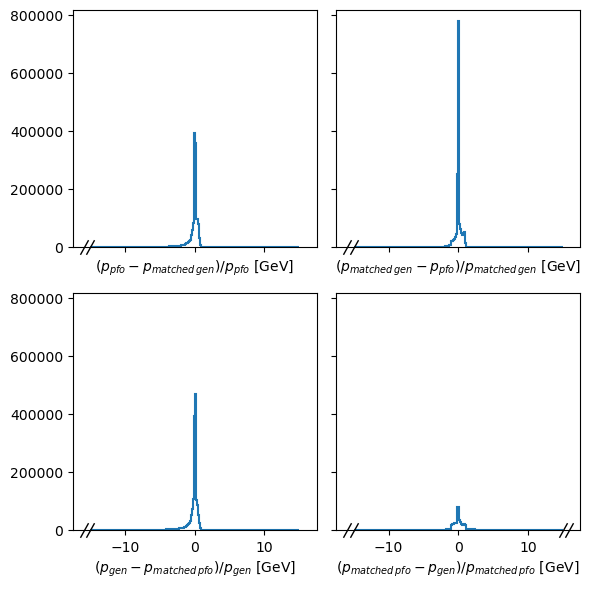

In [10]:
bins = 250
mini = -15
maxi = 15
log = False # plot on a log scale 

p_diff_pgp = (events.PandoraPFOs.p - ak.mean(events.PandoraPFOs.matched_gen.p,axis=2))/events.PandoraPFOs.p
p_diff_pgg = (-events.PandoraPFOs.p + ak.mean(events.PandoraPFOs.matched_gen.p,axis=2))/ak.mean(events.PandoraPFOs.matched_gen.p,axis=2)

p_diff_gpg = ak.drop_none((events.MCParticlesSkimmed.p - ak.mean(events.MCParticlesSkimmed.matched_pfos.p,axis=2))/events.MCParticlesSkimmed.p)
p_diff_gpp = ak.drop_none((-events.MCParticlesSkimmed.p + ak.mean(events.MCParticlesSkimmed.matched_pfos.p,axis=2))/ak.mean(events.MCParticlesSkimmed.matched_pfos.p,axis=2))

diff_hist = {
    "pgp": hda.Hist.new.Reg(
        bins, mini, maxi, name="pt", label="$(p_{pfo}-p_{matched \, gen})/p_{pfo}$ [GeV]"
    )
    .Double()
    .fill(ak.flatten(p_diff_pgp)),
    
    "pgg": hda.Hist.new.Reg(
        bins, mini, maxi, name="pt", label="$(p_{matched \, gen}-p_{pfo})/p_{matched \, gen}$ [GeV]"
    )
    .Double()
    .fill(ak.flatten(p_diff_pgg)),
    
    "gpg": hda.Hist.new.Reg(
        bins, mini, maxi, name="pt", label="$(p_{gen}-p_{matched \, pfo})/p_{gen}$ [GeV]"
    )
    .Double()
    .fill(ak.flatten(p_diff_gpg)),
    
    "gpp": hda.Hist.new.Reg(
        bins, mini, maxi, name="pt", label="$(p_{matched \, pfo}-p_{gen})/p_{matched \, pfo}$ [GeV]"
    )
    .Double()
    .fill(ak.flatten(p_diff_gpp)),
}

out = dask.compute(diff_hist)[0]

fig,axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6, 6))
axs = axs.flatten()

out["pgp"].plot1d(ax=axs[0],label='')
out["pgg"].plot1d(ax=axs[1],label='')
out["gpg"].plot1d(ax=axs[2],label='')
out["gpp"].plot1d(ax=axs[3],label='')

if log:
    for n in range(4):
        axs[n].set_yscale('log')

plt.tight_layout()

### Example 7
Make 2 jets out of all of the PFOs using exclusive clustering and plot their invariant mass.

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


{'from-uproot-08f9d2051ab3e4579ef30993895d2a69': ['PandoraPFOs.y',
  'PandoraPFOs.x',
  'PandoraPFOs.z',
  'PandoraPFOs.t']}

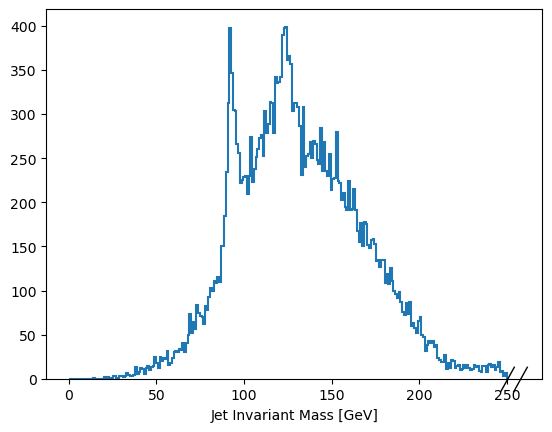

In [11]:
bins = 251
mini = 0
maxi = 250

jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1)
clstr = fastjet.ClusterSequence(events.PandoraPFOs, jetdef).exclusive_jets(n_jets=2)

jets = ak.zip(
    {
        'x': clstr["px"],
        'y': clstr["py"],
        'z': clstr["pz"],
        't': clstr["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

jetpair = ak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs

jet_hist = (
    hda.Hist.new.Reg(bins, mini, maxi, name="energy", label="Jet Invariant Mass [GeV]") 
    .Double()
    .fill(ak.flatten((jetpair.jet1 + jetpair.jet2).mass))
)

jet_hist.compute().plot1d(label='Jets')
dak.necessary_columns(jet_hist)

## Still To-Do 
- finish up adding in the last of the links 
- follow up with the fastjet bug https://github.com/scikit-hep/fastjet/issues/238
